In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from modules.TextPreProcessor import removeShortDocs, removeStopWords, stemSentences

ps = PorterStemmer()
nltk_stop_words = set(stopwords.words('english'))

file = '/home/ifte/amiebot_project/MyAI/AI-system/Summarization Models/Translated_text_mobicontrol_Page01_JP_to_En.txt'
file = open(file , 'r')
raw_data = file.read()

####################################
# PRE-PROCESSING
####################################

# split document into sentences and strip whitespace (delimeted by line)
sentences = raw_data.split('.')
sentences = map(lambda sentence: sentence.strip(), sentences)
sentences = list(sentences)


In [ ]:
sentences

In [ ]:
tokenized_sentence = sent_tokenize(raw_data)
tokenized_sentence

In [ ]:
min_sentence_length = 30

# remove sentences that do not contribute meaning by assuming short sentences have less meaning
sentences = removeShortDocs(sentences, min_sentence_length)
sentences = list(sentences)
sentences

In [ ]:

# remove stop words from all sentences
processedSentences = removeStopWords(sentences, nltk_stop_words)
processedSentences

In [ ]:
# stem all tokens of all sentences
processedSentences = stemSentences(processedSentences, ps)
processedSentences

#####################################



In [ ]:
sentences

In [ ]:
# data = sent_tokenize(raw_data)
# data

In [ ]:
data = processedSentences
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]
tagged_data

In [ ]:
# df[df['page']==0].parsed.values

max_epochs = 20
vec_size = 300
alpha = 0.025
wnd=10
m_lpha=0.065

model = Doc2Vec(vector_size = vec_size,
                alpha=alpha, 
                min_alpha=m_lpha,
                min_count=1,
                dm =1,
                window=wnd)

#Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

In [ ]:
# d2v_model = Doc2Vec(all_content_train, size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
# d2v_model.train(all_content_train, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

# d2v_model.save("d2v.model")
# print("Model Saved")

In [ ]:
d2v_model= Doc2Vec.load("d2v.model")

kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
clusters=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)


In [ ]:
datapoint
clusters
d2v_model.docvecs.doctag_syn0

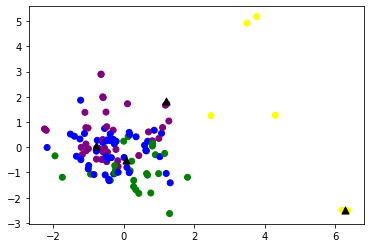

In [44]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in clusters]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=50, c='#000000')
plt.show()

In [64]:
d2v_model= Doc2Vec.load("d2v.model")
# cluster our tokenized sentences into 10 groups
kMeansCluster = KMeans(n_clusters=10)
kMeansCluster.fit(d2v_model.docvecs.doctag_syn0)
clusters = kMeansCluster.labels_.tolist()

/home/ifte/amiebot_project/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


In [ ]:
centroidpoint

In [65]:
####################################
# Organize Cluster Results
####################################

# Create new dictionary that tracks which cluster each sentence belongs to
# keeps copy of original sentences and stemmed sentences
# sentenceDictionary { idx: { text: String, stemmed: String, cluster: Number } }
sentenceDictionary = {}
for idx, sentence in enumerate(sentences):
	sentenceDictionary[idx] = {}
	sentenceDictionary[idx]['text'] = sentence
	sentenceDictionary[idx]['cluster'] = clusters[idx]
	sentenceDictionary[idx]['stemmed'] = processedSentences[idx]


# Create new dictionary that contains 1 entry for each cluster
# each key in dictionary will point to array of sentences, all of which belong to that cluster
# we attach the index to the sentenceDictionary object so we can recall the original sentence
clusterDictionary = {}
for key, sentence in sentenceDictionary.items():
	if sentence['cluster'] not in clusterDictionary:
		clusterDictionary[sentence['cluster']] = []
	clusterDictionary[sentence['cluster']].append(sentence['stemmed'])
	sentence['idx'] = len(clusterDictionary[sentence['cluster']]) - 1


vectorizer = TfidfVectorizer()

####################################
# Calculate Cosine Similarity Scores
####################################		

# For each cluster of sentences,
# Find the sentence with highet cosine similarity over all sentences in cluster
maxCosineScores = {}
for key, clusterSentences in clusterDictionary.items():
	maxCosineScores[key] = {}
	maxCosineScores[key]['score'] = 0
	tfidf_matrix = vectorizer.fit_transform(clusterSentences)
	cos_sim_matrix = cosine_similarity(tfidf_matrix)
    
	for idx, row in enumerate(cos_sim_matrix):
		sum = 0
		for col in row:
			sum += col
		if sum > maxCosineScores[key]['score']:
			maxCosineScores[key]['score'] = sum
			maxCosineScores[key]['idx'] = idx


####################################
# Construct Document Summary
####################################	

# for every cluster's max cosine score,
# find the corresponding original sentence
resultIndices = []
i = 0
for key, value in maxCosineScores.items():
	cluster = key
	idx = value['idx']
	stemmedSentence = clusterDictionary[cluster][idx]
	# key corresponds to the sentences index of the original document
	# we will use this key to sort our results in order of original document
	for key, value in sentenceDictionary.items():
		if value['cluster'] == cluster and value['idx'] == idx:
			resultIndices.append(key)

resultIndices.sort()

# Iterate over sentences and construct summary output
result = ''
for idx in resultIndices:
	result += sentences[idx] + ' '
		

print(result)